# Загрузка данных #

In [8]:
from sklearn.metrics import mean_squared_error, precision_score, balanced_accuracy_score, f1_score, recall_score, accuracy_score, plot_roc_curve, roc_auc_score, roc_curve
from sklearn.preprocessing import binarize
import csv
import numpy as np
from typing import List, Dict
def printMetrics(Y_files_test, files_preds, threshold=0.5):
    print("rms: %f" % np.sqrt(mean_squared_error(Y_files_test, files_preds)))
    print("Precision score: ",  precision_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=threshold)))
    print("Recall score: ",  recall_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=threshold)))
    print("Accuracy score: ",  accuracy_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=threshold)))
    print("Balanced accuracy score: ",  balanced_accuracy_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=threshold)))
    print("F1 score: ",  f1_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=threshold)))
    print("F1 weighted score: ",  f1_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=threshold), average = 'weighted'))

def readDataset(csvFilePath:str)->(List, List ):
    csv_file = csvFilePath
    files = []
    labels = []
    snr = []
    data_folder_name = csv_file[:csv_file.rfind('/')] + '/audio/'
    with open(csv_file) as csv_file_obj:
        rdr = csv.reader(csv_file_obj, delimiter=';')
        skip_first = True
        for row in rdr:
            if not skip_first:
                files.append(data_folder_name + row[0])
                labels.append(int(row[1]))
                snr.append(float(row[2]))
            skip_first = False
    return (files, labels)
files = []
labels = []
filesA, labelsA = readDataset('file_path')
files.extend(filesA)
labels.extend(labelsA)
print('Total files: ' + repr(len(files)))
print('Labeled \'1\': '+repr(np.sum(labels)) )

Total files: 1767
Labeled '1': 744


In [9]:
# data_folder_name = csv_file[:csv_file.rfind('/')] + '/audio/'
# my_file_num = 64
my_file_num = np.flatnonzero(labels)[703] # так можно перебирать файлы с label=1 для просмотра
print(f'We study: {files[my_file_num]} with label 1 {labels[my_file_num]}')

We study: /home/latna/aponom/whales/Canada/data/clips/dataset_A/train/audio/A_1629.wav with label 1 1


In [10]:
my_file_num

1623

In [11]:
files[0]

'/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/audio/A_0.wav'

In [12]:
import librosa
import csv
import numpy as np

x , sr = librosa.load('file_path')


def trim_and_fade(x):
    trim_in_out = 1000
    fade_in_out = 1000
    x = x[trim_in_out:-trim_in_out]
    x[:fade_in_out] = x[:fade_in_out] * np.array(range(0, fade_in_out))/fade_in_out
    x[-fade_in_out:] = x[-fade_in_out:] * (fade_in_out - 1 - np.array(range(0, fade_in_out)))/fade_in_out
    return x
x = trim_and_fade(x)
print('Sample rate: %0.3f s'  % sr)
print('Duration: %0.3f s'  % (x.shape[0] / sr))

Sample rate: 22050.000 s
Duration: 2.910 s


# Визуализируем признаки #

In [13]:
#так можешь послушать, что там (но без фильтров не услышать). может быть без нормализации не услышишь? может быть стоит тогда данные все предварительно нормализовать? или мы испортим инфомацию об энергии? значит их все надо отмасштабировать на одну величину. 
import IPython.display as ipd
ipd.Audio('file_path')

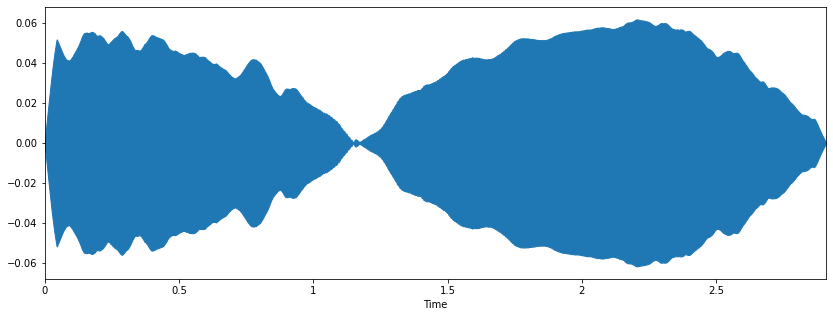

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

(0.0, 500.0)

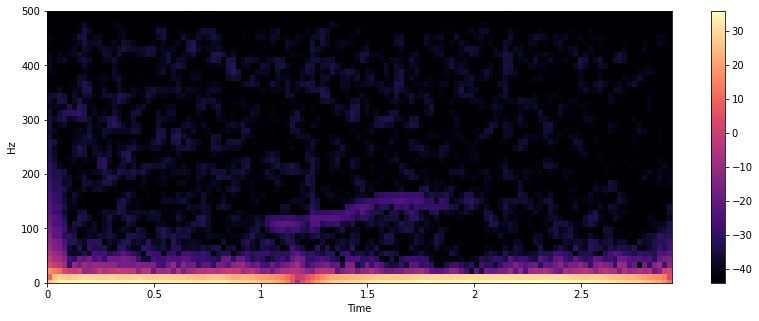

In [15]:
# всегда полезно смотреть спектрограмму! она содержит почи всю информацию! #
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.ylim((0, 500))

(0.0, 512.0)

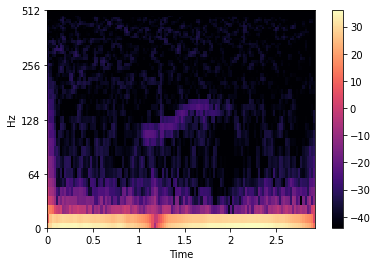

In [16]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.ylim((0, 512))

# Feature extraction from Audio signal #
Всё наше предсказание своидтся к тому, чтобы в звуковом окне посчитать признаки и дальше уже используя эти признаки, произвести классификацию. дальше идут разные признаки и как их извлекать. в одном файле у нас лежит инфа о том, где есть аномалия, а где нет. эту инфу мы будем использовать, чтобы построить обущающую выборку

## 1. Spectral Centroid ##
Спектральный центроид указывает, на какой частоте сосредоточена энергия спектра, или, другими словами, он указывает, где расположен ”центр масс” звука. Это похоже на средневзвешенное значение:

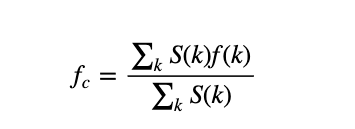

где S(k) - спектральная величина в ячейке частоты k, f(k) - частота в ячейке k.

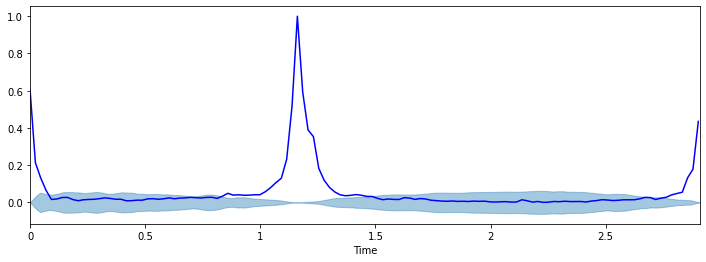

In [17]:
import sklearn
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape
(775,)
# Computing the time variable for visualization
plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='b')

In [18]:
len(t), len(x),len(spectral_centroids)

(126, 64173, 126)

## 2. Spectral Rolloff ##
Это мера формы сигнала. Он представляет частоту, при которой высокие частоты снижаются до 0. Чтобы получить его, мы должны рассчитать долю ячеек в спектре мощности, где 85% его мощности приходится на более низкие частоты.

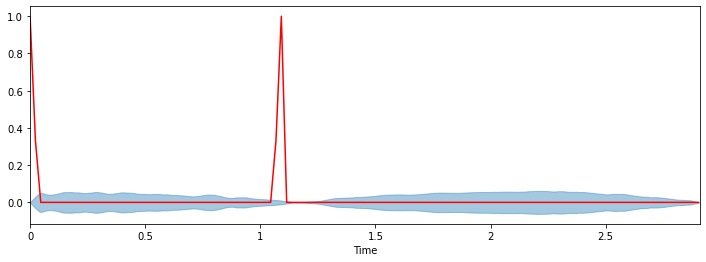

In [19]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
plt.figure(figsize=(12, 4))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')


## 3. Spectral Bandwidth ##

Спектральная полоса пропускания определяется как ширина полосы света при половине максимального пика (или полная ширина при половинном максимуме [FWHM]) и представлена двумя вертикальными красными линиями и λSB на оси 
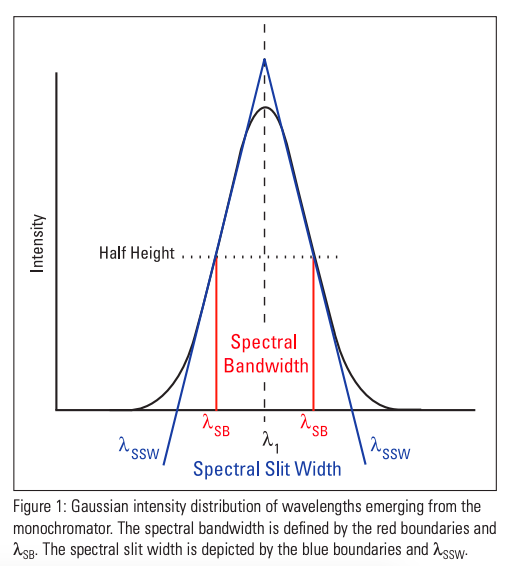

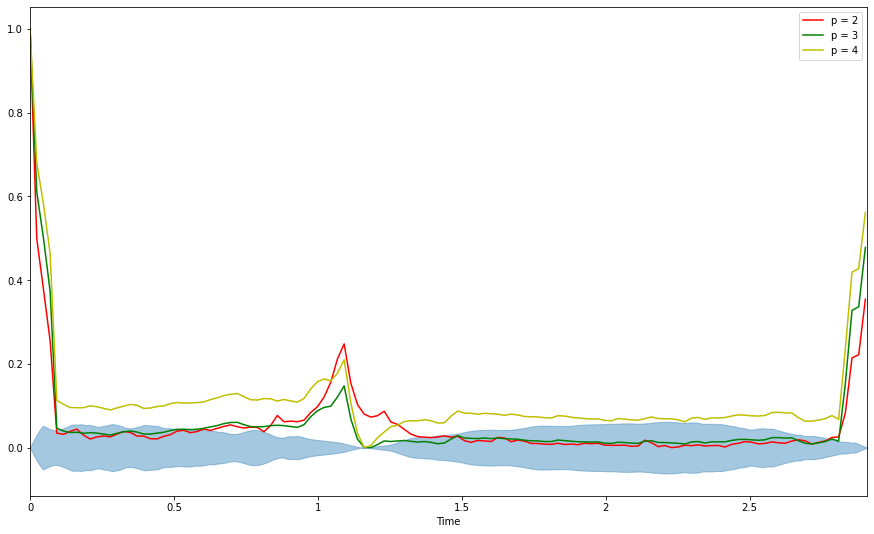

In [20]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=4)[0]
plt.figure(figsize=(15, 9))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

## 4. Zero-Crossing Rate ##

Очень простой способ измерения плавности сигнала - это вычислить количество пересечений нуля в сегменте этого сигнала. Речевой сигнал колеблется медленно — например, сигнал частотой 100 Гц пересекает ноль 100 раз в секунду, в то время как беззвучный фрикативный сигнал может иметь 3000 пересечений нуля в секунду.
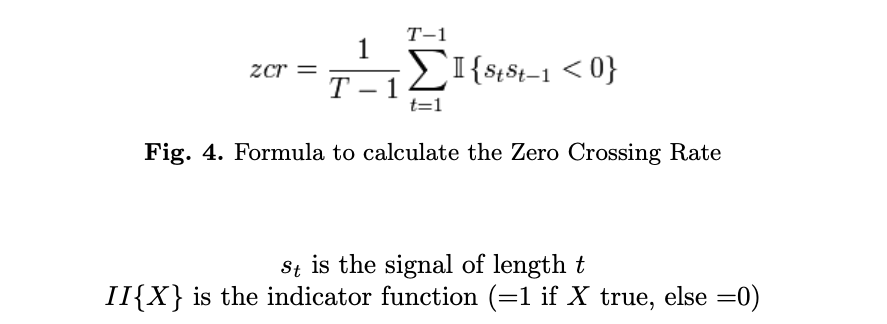
<br> Обычно он имеет более высокие значения для сильно ударных звуков, таких как в металле и роке. Теперь давайте визуализируем это и посмотрим, как мы вычисляем скорость пересечения нуля.

## 5. Mel-Frequency Cepstral Coefficients(MFCCs) ##

Кепстральные коэффициенты малой частоты (MFCC) сигнала представляют собой небольшой набор характеристик (обычно около 10-20), которые кратко описывают общую форму спектральной огибающей. Он моделирует характеристики человеческого голоса.

(100, 126)


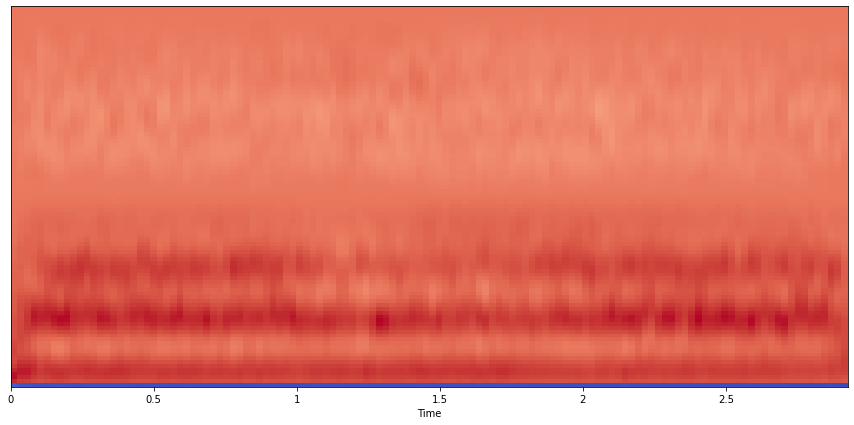

In [21]:
mfccs = librosa.feature.mfcc(x, sr=sr,  n_mfcc=100, lifter=50)
print(mfccs.shape)
#Displaying  the MFCCs:
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

## 6. Chroma feature ##
Признак или вектор цветности обычно представляет собой вектор признаков из 12 элементов, указывающий, сколько энергии каждого класса высоты тона {C, C#, D, D#, E, ..., B} присутствует в сигнале. Короче говоря, это обеспечивает надежный способ описания меры сходства между музыкальными произведениями.

librosa.feature.chroma_stft используется для вычисления характеристик цветности.

/home/latna/.local/lib/python3.9/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


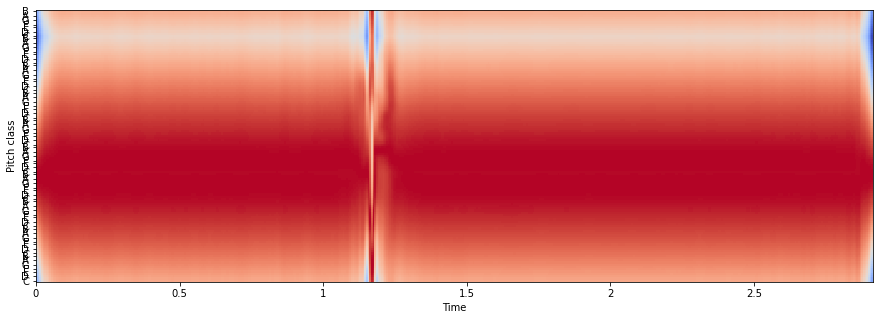

In [22]:
hop_length = 128
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length, n_chroma=120)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm', )

Что-то с MFCC и Chroma feature все плохо.  *Или мы не умеем ими пользоваться!*

# Альтернативный набор признаков #
 посчитаем те же признаки, но:
* офильтруем сигнал в диапазоне кита до извлечения признаков,
* rms будет нормированный



In [23]:
import numpy as np
from math import pi, cos
freq_range = [80, 200]
improved_features_cached = [None, None]
def improved_features(wp, ws, full, sr, id):

    if improved_features_cached[0] != id:
        df = (1.0*sr)/len(full)
        nf11 = round(freq_range[0]/df * 0.9)
        nf12 = round(freq_range[0]/df * 1.1)
        nf21 = round(freq_range[1]/df * 0.9)
        nf22 = round(freq_range[1]/df * 1.1)
        
        yy = np.fft.fft(full)
#        plt.loglog(abs(yy))
        yy[:nf11] = 0
        yy[nf11:nf12] = yy[nf11:nf12] * np.array(
            [0.5 - 0.5 * cos((nf-nf11)*pi/(nf12-nf11))for nf in range(nf11, nf12)])
        yy[nf21:nf22] = yy[nf21:nf22] * np.array(
            [0.5 + 0.5 * cos((nf-nf21)*pi/(nf22-nf21))for nf in range(nf21, nf22)])
        yy[nf22:] = 0
        filtered = 2 * np.real( np.fft.ifft(yy) )
#        plt.loglog(abs(yy))
#        plt.show()
        improved_features_cached[:] = [id, filtered]
    else:
        filtered = improved_features_cached[1]
    fin = min(wp+ws, len(filtered))
    wx = filtered[wp:fin]
    rms_norm = np.std(wx) / np.std(filtered)
    spec_cent = librosa.feature.spectral_centroid(wx, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(wx, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(wx, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(wx)
    features = [rms_norm, np.mean(spec_cent), np.mean(spec_bw), np.mean(rolloff), np.mean(zcr)] 
    return features
improved_features_dict = {'f0':'rms_norm_band', 'f1': 'spec_cent_band', 'f2': 'spec_bw_band', 'f3':'rolloff_band', 'f4':'zcr_band'}

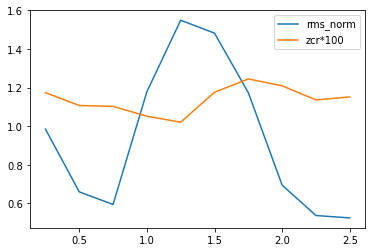

In [24]:
# Проверим improved_features
wpp = np.array([int(sr * 0.25 * n) for n in range(0,10)])
ws = int(0.5*sr)
res= np.ndarray((wpp.shape[0], 5))
for j in range(0, wpp.shape[0]):
    res_j = improved_features(wpp[j], ws, x, sr, -1)
    res[j,:] =res_j
tt = (wpp+ws*0.5) / (sr*1.0)
plt.plot(tt, res[:,0])
plt.plot(tt, res[:,4]*100)
plt.legend(('rms_norm', 'zcr*100'))
plt.show()

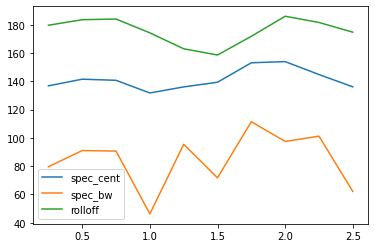

In [25]:
plt.plot(tt, res[:,1])
plt.plot(tt, res[:,2])
plt.plot(tt, res[:,3])
plt.legend(('spec_cent', 'spec_bw', 'rolloff'))
plt.show()

Графики выглядят более или менее осмысленно, особенно rms_norm.
Можно пробовать запихивать в классификатор. <br> Но мы пока этого делать не будем. Попробуем для лаконичности использовать библиотечные функии для фильтрации. <br>
Более того, сделаем нарезку в разных частотных диапазонах

In [26]:
from scipy import signal
from scipy.signal import butter, lfilter
import numpy as np
freq_range = [80, 200]
sos = signal.butter(5, [80, 200], 'bandpass', fs=sr, output='sos')

def improved_features_lib(_wx,sr):

    wx = signal.sosfilt(sos, _wx)
    rms = librosa.feature.rms(wx)
    spec_cent = librosa.feature.spectral_centroid(wx, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(wx, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(wx, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(wx)
    features = [np.mean(rms), np.mean(spec_cent), np.mean(spec_bw), np.mean(rolloff), np.mean(zcr)] 
    return features

improved_features_dict = {'f0':'rms_norm_band', 'f1': 'spec_cent_band', 'f2': 'spec_bw_band', 'f3':'rolloff_band', 'f4':'zcr_band'}

In [27]:
files[-1]

'/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/audio/A_1772.wav'

In [28]:
# improved_features_lib2 – этот набор признаков работает пока лучше всего
from scipy import signal
from scipy.signal import butter, lfilter
import numpy as np
import librosa


# audio_data = data_folder_name + files[my_file_num]
x , sr = librosa.load( files[0])
ws = int(0.5*sr)   # (window size) увеличим размер окна в два раза
wd = int(ws * 0.25) # (window delta) сдвиг. соответственно оставим как раньше, поэтому уже берём четверть
# x = trim_and_fade(x)
wx = x[:ws] 

rms = librosa.feature.rms(wx)
chroma_stft = librosa.feature.chroma_stft(wx, sr=sr)
spec_cent = librosa.feature.spectral_centroid(wx, sr=sr)
spec_bw = librosa.feature.spectral_bandwidth(wx, sr=sr)
rolloff = librosa.feature.spectral_rolloff(wx, sr=sr)
zcr = librosa.feature.zero_crossing_rate(wx)
mfcc = librosa.feature.mfcc(wx, sr=sr)

# создаём набор признаков для improved_features_lib2
features_dict = {'f0':'rms_mean', 'f1':'chroma_stft_mean', 'f2': 'spec_cent_mean', 'f3': 'spec_bw_mean', 'f4':'rolloff_mean', 'f5':'zcr_mean', 'f6': 'mfcc_mean'}
for i in range(len(rms[0])):
    features_dict[f'f{len(features_dict)}']=f'rms_{i}'
i = 0
for raw in chroma_stft:
    for j in range(len(raw)):
        features_dict[f'f{len(features_dict)}'] = f'chroma_stft_{i}'
        i = i + 1
for i in range(len(spec_cent[0])):
    features_dict[f'f{len(features_dict)}'] =f'spec_cent_{i}'
for i in range(len(spec_bw[0])):
    features_dict[f'f{len(features_dict)}'] = f'spec_bw_{i}'
for i in range(len(rolloff[0])):
    features_dict[ f'f{len(features_dict)}'] = f'rolloff_{i}'
for i in range(len(zcr[0])):
    features_dict[ f'f{len(features_dict)}'] = f'zcr_{i}' 
i = 0
for raw in mfcc:
    for j in range(len(raw)):
        features_dict[f'f{len(features_dict)}'] = f'mfcc_{i}' 
        i = i + 1 
# создаём имена для признаков следующего шага

# features_dict_base = features_dict.copy()

# for key, value in features_dict_base.items():
#   features_dict[f'f{len(features_dict)}']=f'2_{value}'

sos = signal.butter(5, [80, 200], 'bandpass', fs=sr, output='sos')
def improved_features_lib2(_wx, sr):
    """
    Функция которая для окна выдаёт вектор признаков
    """
    wx = signal.sosfilt(sos, _wx)
    rms = librosa.feature.rms(wx)
    chroma_stft = librosa.feature.chroma_stft(wx, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(wx, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(wx, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(wx, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(wx)
    mfcc = librosa.feature.mfcc(wx, sr=sr)
    features = [np.mean(rms), np.mean(chroma_stft), np.mean(spec_cent), np.mean(spec_bw), np.mean(rolloff), np.mean(zcr), np.mean(mfcc)] 
    features.extend(rms[0])
    for i in chroma_stft:
        features.extend(i)
    features.extend(spec_cent[0]) 
    features.extend(spec_bw[0])
    features.extend(rolloff[0])
    features.extend(zcr[0])
    for i in mfcc:
        features.extend(i)
    return features

/home/latna/.local/lib/python3.9/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [29]:
len(features_dict)

821

## Разворачиваем все признаки и нарезаем сигнал полосами  ##
Это работает не лучше, чем развернутые признаки в полосе 50-200Hz.
Поэтому это не используем

In [30]:
#[50,100] [100, 150] [150, 200], ...
freq_ranges = []
begin_freq = 50
while begin_freq < sr:
    freq_ranges.append( (begin_freq, begin_freq*2) )
    begin_freq = begin_freq*2
print(freq_ranges)
from scipy import signal
from scipy.signal import butter, lfilter
import numpy as np
# freq_range = [80, 200]
soss = [] 
for freq_begin, freq_end in freq_ranges[:-2]:
    print(freq_begin)
    print(freq_end)
    soss.append (signal.butter(5, [freq_begin, freq_end], 'bandpass', fs=sr, output='sos') )
def improved_features_lib2_full_band(_wx, sr):

    features = []
    for sos in soss:
        wx = signal.sosfilt(sos, _wx)
        rms = librosa.feature.rms(wx)
        chroma_stft = librosa.feature.chroma_stft(wx, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(wx, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(wx, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(wx, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(wx)
    mfcc = librosa.feature.mfcc(wx, sr=sr)
    features.extend([np.mean(rms), np.mean(chroma_stft), np.mean(spec_cent), np.mean(spec_bw), np.mean(rolloff), np.mean(zcr), np.mean(mfcc)] )
    features.extend(rms[0])
    for i in chroma_stft:
        features.extend(i)
    features.extend(spec_cent[0]) 
    features.extend(spec_bw[0])
    features.extend(rolloff[0])
    features.extend(zcr[0])
    for i in mfcc:
        features.extend(i)
    return features

[(50, 100), (100, 200), (200, 400), (400, 800), (800, 1600), (1600, 3200), (3200, 6400), (6400, 12800), (12800, 25600)]
50
100
100
200
200
400
400
800
800
1600
1600
3200
3200
6400


In [31]:
data_folder_name

'/home/latna/aponom/whales/Canada/data'

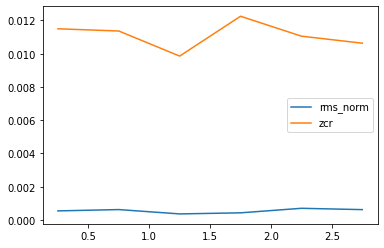

In [32]:
# Проверим improved_features_lib
x , sr = librosa.load(files[my_file_num])
ws = int(0.5*sr)
wp = 0
res = []
tt = []
while wp + ws < len(x):
    res_j = improved_features_lib(x[wp: wp+ws], sr)
    res.append(res_j)
    tt.append( (wp+ws*0.5) / (sr*1.0) )    
    wp = wp + ws 
plt.plot(tt, [r[0] for r in res ] )
plt.plot(tt, [r[4] for r in res ] )
plt.legend(('rms_norm', 'zcr'))
plt.show()

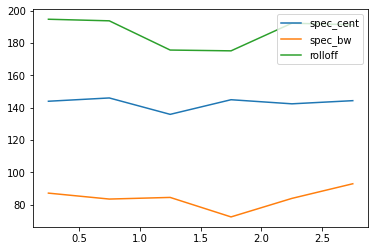

In [33]:
plt.plot(tt,  [r[1] for r in res ] )
plt.plot(tt,  [r[2] for r in res ] )
plt.plot(tt,  [r[3] for r in res ] )
plt.legend(('spec_cent', 'spec_bw', 'rolloff'))
plt.show()

Всё отлично. Библиотечный фильтр работает как надо.

# Построение обучающей выборки (X, Y) #
Признаки извлекать мы научились. Осталось пройти окном по аудиофайлам и создать обучающую выборку вида: <br>
$(X, Y )$, $X$ – матрица признаков, $Y$ – метки <br>
$ X = (x_1, x_2, .., x_i, ..., x_n),  |x_i| = \textit{number of features}$ <br>
$ Y = (y_1, y_2, ..., y_i, ..., y_n), y_i\in \{0, 1\} $
<br>
$ n = \frac{t_{len}} {\textit{window}_{size}}$ 


Но с канадскими данными есть проблема. В приложенным к ним файле разметки присваивается label=1 для всего файла целеиком, который имеет длину 3 с, а кит занимает там только некоторую часть. Беглый просмотр маленькой выборки файлов показал, что они нарезаны так, что сигнал кита примерно по центру, но смещается влево-вправо от файла к файлу, т.е. он может быть [0.9, 1.8], а может [1.4, 2.1], к примеру. Если для файла стоит label=1, то:
* на отметке 1.5 всегда есть кит,
* кит целиком заватывает интервал [1.4, 1.8] в 82% случаях,
* кит по-максиуму бывает в интервале [0.9, 2.2].

По этому для обучения решено отмечать окна:
* в интервале [1.4, 1.8] как $y_j=1$,
* вне интервала [0.9, 2.2] как $y_j=0$,
* в интервалах [0.9, 1.4] и [1.8, 2.2] не использовать для обучения

(Это справедливо для папки A и с учетом того, что я обрезаю 1000 отсчетов сначала файла)

Осталось пройтись окном по каждому файлу и разбить на окна


In [34]:
#возьмём окно длинной 0.25 секунды
# ws = int(0.25*sr)   # (window size) размер окна измеряемый в сэмплах = time_in_sec * sample_rate
# wd = int(ws * 0.5) # (window delta) сдвиг. возьмём в пол окна, можно было бы и в четверть взять
# ws = int(0.5*sr)   # (window size) увеличим размер окна в два раза
# wd = int(ws * 0.25) # (window delta) сдвиг. соответственно оставим как раньше, поэтому уже берём четверть

In [35]:
# features_dict = {'f0':'rms', 'f1': 'spec_cent', 'f2': 'spec_bw', 'f3':'rolloff', 'f4':'zcr'} #, 'f5': 'mfcc'}
# тут уберем mfcc и chrome потому что с ними сложность

# а тут вернем их:
features_dict = {'f0':'rms_mean', 'f1':'chroma_stft_mean', 'f2': 'spec_cent_mean', 'f3': 'spec_bw_mean', 'f4':'rolloff_mean', 'f5':'zcr_mean', 'f6': 'mfcc_mean'}


In [36]:
len(x)/len(wx)

6.002086167800454

In [37]:
len(features_dict)

7

In [38]:
files[my_file_num]

'/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/audio/A_1629.wav'

In [39]:
# создаём словарь признаков для improved_features_lib2_full_band
audio_data = files[my_file_num]
x , sr = librosa.load(audio_data)
x = trim_and_fade(x)
wx = x[:ws] 

rms = librosa.feature.rms(wx)
chroma_stft = librosa.feature.chroma_stft(wx, sr=sr)
spec_cent = librosa.feature.spectral_centroid(wx, sr=sr)
spec_bw = librosa.feature.spectral_bandwidth(wx, sr=sr)
rolloff = librosa.feature.spectral_rolloff(wx, sr=sr)
zcr = librosa.feature.zero_crossing_rate(wx)
mfcc = librosa.feature.mfcc(wx, sr=sr)


# features_dict = {'f0':'rms_mean', 'f1':'chroma_stft_mean', 'f2': 'spec_cent_mean', 'f3': 'spec_bw_mean', 'f4':'rolloff_mean', 'f5':'zcr_mean', 'f6': 'mfcc_mean'}
features_dict = {}

for freq_begin, freq_end in freq_ranges[:-2]:
    features_dict[f'f{len(features_dict)}']=f'{freq_begin}_{freq_end}_rms_mean'
    features_dict[f'f{len(features_dict)}']=f'{freq_begin}_{freq_end}_chroma_stft_mean'
    features_dict[f'f{len(features_dict)}']=f'{freq_begin}_{freq_end}_spec_cent_mean'
    features_dict[f'f{len(features_dict)}']=f'{freq_begin}_{freq_end}_spec_bw_mean'
    features_dict[f'f{len(features_dict)}']=f'{freq_begin}_{freq_end}_rolloff_mean'
    features_dict[f'f{len(features_dict)}']=f'{freq_begin}_{freq_end}_zcr_mean'
    features_dict[f'f{len(features_dict)}']=f'{freq_begin}_{freq_end}_mfcc_mean'
    # features_dict = {'f0':'rms_mean', 'f1':'chroma_stft_mean', 'f2': 'spec_cent_mean', 'f3': 'spec_bw_mean', 'f4':'rolloff_mean', 'f5':'zcr_mean', 'f6': 'mfcc_mean'}
    for i in range(len(rms[0])):
        features_dict[f'f{len(features_dict)}']=f'rms_{i}'
    i = 0
    for raw in chroma_stft:
        for j in range(len(raw)):
            features_dict[f'f{len(features_dict)}'] = f'chroma_stft_{i}'
            i = i + 1

    for i in range(len(spec_cent[0])):
        features_dict[f'f{len(features_dict)}'] =f'spec_cent_{i}'

    for i in range(len(spec_bw[0])):
        features_dict[f'f{len(features_dict)}'] = f'spec_bw_{i}'

    for i in range(len(rolloff[0])):
        features_dict[ f'f{len(features_dict)}'] = f'rolloff_{i}'

    for i in range(len(zcr[0])):
        features_dict[ f'f{len(features_dict)}'] = f'zcr_{i}' 

    i = 0
    for raw in mfcc:
        for j in range(len(raw)):
            features_dict[f'f{len(features_dict)}'] = f'mfcc_{i}' 
            i = i + 1 

# Извлечение признаков и формирование Train/Test #

In [40]:
from sklearn.model_selection import train_test_split
train_files, test_files, train_labels, test_labels  = train_test_split(files, labels, test_size=0.3, random_state=666) 

In [41]:
# новое 
import numpy as np
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.simplefilter("ignore")
# good = [1.4, 1.6] # временной интервал, где точно находится кит (так делали для первого хорошего результата для A на A)
good = [1.4, 1.8] # временной интервал, где точно находится кит (так делали для первого хорошего результата для A на A)
bad = [0.9, 2.2] # временной интервал, в котором точно нет кита
# по этотому файлу проверимся потом, а сейчас обучаться не будем

X_train = [] 
Y_train = []
X_test = []
Y_test = []

X_all = []
file_id_all=[]
for id, file in tqdm(enumerate(files), total=len(files)):
    x , sr = librosa.load(file)
    # x = trim_and_fade(x)
    wp = 0  # (window position) начинаем бежать с самого начала, с 0 сэмпла
    while wp + ws < len(x):
        if labels[id] > 0:
            tc = (wp + ws*0.5) / sr
            if (tc < bad[0]) or (tc > bad[1]):
                into_signal = 0
            else:
                if (tc >= good[0]) and (tc <= good[1]):
                    into_signal = 1
                else:
                    wp = wp + wd   
                    continue
        else:
            into_signal = 0

        features = []
        wx = x[wp:wp+ws] # window x=
        features = improved_features_lib2(wx, sr)
        if file in train_files:
            X_train.append(features)
            Y_train.append(into_signal)
        else:
            X_test.append(features)
            Y_test.append(into_signal)
        wp = wp + wd

warnings.resetwarnings()

  0%|          | 0/1767 [00:00<?, ?it/s]

In [42]:
# посмотрем на размер обучающей выборки
len(X_train),len(X_train[1]), len(Y_train)

/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(22281, 821, 22281)

Отлично! Обучающую выборку построили. Можно теперь её разделить на  train-test

In [43]:
# посмотрим насколько у нас не сбалансированные данные
# scale_pos_weight = total_negative_examples / total_positive_examples
(len(Y_train) - sum(Y_train)) / sum(Y_train)

13.146666666666667

In [44]:
# оценим accuracy для константного предсказателя 
(len(Y_train) - sum(Y_train)) / len(Y_train)

0.9293119698397738

Получилось, что негативных примеров, у нас в ___ раз больше, чем позитивных. Обычная история. Значит будем подкручивать веса для позитивных образцов при обучении модели.



---



**Пробуем использовать XGBoost**

In [45]:
import xgboost as xgb

In [49]:
model = xgb.XGBRegressor(n_estimators = 250, scale_pos_weight=9)

In [50]:
%%time
model.fit(np.array( X_train) ,np.array(Y_train), verbose=True)

CPU times: user 59min 41s, sys: 0 ns, total: 59min 41s
Wall time: 5min 10s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=250, n_jobs=24, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=9, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
# the average information gain across all splits the feature is used in.
{ features_dict[key]:value for key, value in model.get_booster().get_score(importance_type='gain').items() }

{'50_100_chroma_stft_mean': 23.649608035573983,
 '50_100_rolloff_mean': 6.326881399917687,
 'zcr_19': 29.337831671686846,
 'zcr_13': 19.138051118144997,
 'chroma_stft_84': 1.1455234664489748,
 'chroma_stft_195': 1.2072533186561183,
 'spec_cent_20': 1.0001215161225927,
 'chroma_stft_188': 1.4568936726579313,
 'rms_19': 4.922015260065,
 'chroma_stft_42': 0.26788741479837846,
 'rms_4': 6.570415960435648,
 'chroma_stft_115': 2.013326354277778,
 'rms_16': 1.4927641479238334,
 'rms_21': 1.57831197862573,
 'chroma_stft_3': 3.2908755791790507,
 'chroma_stft_171': 2.163712523126667,
 'chroma_stft_77': 1.1459556487736875,
 'chroma_stft_95': 1.430807556246111,
 'chroma_stft_138': 1.62128779270175,
 'spec_bw_11': 3.310465334736388,
 'chroma_stft_129': 0.4277972659189474,
 'mfcc_307': 2.6510231927450003,
 'mfcc_290': 2.78337275074,
 'chroma_stft_118': 0.5862531058307896,
 'spec_bw_6': 11.556009148815429,
 '50_100_zcr_mean': 7.95510976477962,
 'chroma_stft_261': 1.3625658088753339,
 'chroma_stft_61'

In [52]:
 # the number of times a feature is used to split the data across all trees.
{ features_dict[key]:value for key, value in model.get_booster().get_score(importance_type='weight').items() }

{'50_100_chroma_stft_mean': 320,
 '50_100_rolloff_mean': 64,
 'zcr_19': 19,
 'zcr_13': 4,
 'chroma_stft_84': 39,
 'chroma_stft_195': 34,
 'spec_cent_20': 27,
 'chroma_stft_188': 29,
 'rms_19': 10,
 'chroma_stft_42': 37,
 'rms_4': 29,
 'chroma_stft_115': 27,
 'rms_16': 18,
 'rms_21': 26,
 'chroma_stft_3': 47,
 'chroma_stft_171': 21,
 'chroma_stft_77': 16,
 'chroma_stft_95': 18,
 'chroma_stft_138': 16,
 'spec_bw_11': 36,
 'chroma_stft_129': 19,
 'mfcc_307': 12,
 'mfcc_290': 5,
 'chroma_stft_118': 38,
 'spec_bw_6': 35,
 '50_100_zcr_mean': 50,
 'chroma_stft_261': 30,
 'chroma_stft_61': 21,
 'rolloff_10': 2,
 'chroma_stft_190': 33,
 'chroma_stft_228': 20,
 'spec_bw_9': 40,
 'spec_bw_12': 55,
 'mfcc_222': 7,
 'chroma_stft_56': 37,
 'chroma_stft_212': 26,
 'chroma_stft_218': 17,
 'chroma_stft_186': 27,
 'chroma_stft_111': 15,
 'chroma_stft_33': 31,
 '50_100_spec_cent_mean': 136,
 'chroma_stft_34': 32,
 'chroma_stft_225': 18,
 'spec_bw_10': 45,
 'chroma_stft_137': 38,
 'spec_cent_6': 17,
 'chr

In [53]:
preds = model.predict(np.array(X_test))

In [54]:
printMetrics(Y_test, preds, 0.5)

rms: 0.182758
Precision score:  0.7197724039829303
Recall score:  0.7701674277016742
Accuracy score:  0.9638178415470992
Balanced accuracy score:  0.8740916370736918
F1 score:  0.7441176470588236
F1 weighted score:  0.9643831922377716


/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Constant negative: ROC AUC=0.500
Logistic: ROC AUC=0.956


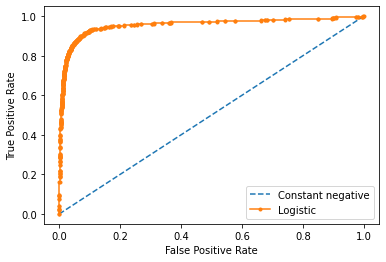

In [55]:
# improved_features_lib2:  для нового train test
from matplotlib import pyplot
ns_probs = [0 for _ in range(len(Y_test))]
# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)
lr_auc = roc_auc_score(Y_test, preds)
# summarize scores
print('Constant negative: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, preds)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Constant negative')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()



---



In [ ]:
# для задач бинарной классификации стоит смотреть roc_auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
print('Mean ROC AUC: %.5f' % np.mean(cross_val_score(model, X_train+X_test, Y_train+Y_test, scoring='roc_auc', cv=cv, n_jobs=-1)))



---



**Используем gradient boosting из библиотеки oneDAL**

In [60]:
import daal4py as d4p

In [61]:
dal_X_train = X_train
dal_Y_train = [[i] for i in Y_train]

dal_X_test = X_test
dal_Y_test = [[i] for i in Y_test]

In [62]:
dal_model = d4p.gbt_regression_training()

In [63]:
%%time
dal_train_res = dal_model.compute(np.array(dal_X_train), np.array(dal_Y_train))

CPU times: user 4min 6s, sys: 0 ns, total: 4min 6s
Wall time: 38.3 s


In [64]:
dal_model_test = d4p.gbt_regression_prediction()

In [65]:
predict_result = dal_model_test.compute(np.array(dal_X_test), dal_train_res.model)

In [66]:
printMetrics(dal_Y_test, predict_result.prediction, 0.5) 

rms: 0.167040
Precision score:  0.8050541516245487
Recall score:  0.6788432267884322
Accuracy score:  0.9668330214181743
Balanced accuracy score:  0.8333955002372024
F1 score:  0.7365813377374071
F1 weighted score:  0.9655172975114271


/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Constant negative: ROC AUC=0.500
Logistic: ROC AUC=0.956


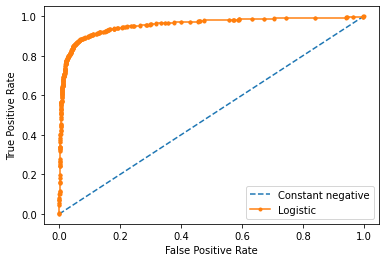

In [67]:
# improved_features_lib2:  для нового train test
from matplotlib import pyplot
ns_probs = [0 for _ in range(len(Y_test))]
# calculate scores
ns_auc = roc_auc_score(dal_Y_test, ns_probs)
lr_auc = roc_auc_score(dal_Y_test, predict_result.prediction)
# summarize scores
print('Constant negative: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(dal_Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(dal_Y_test, predict_result.prediction)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Constant negative')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plo



---



# Сравним результаты #

rms:                   XGB:  <font color='green'>0.182758</font>             || oneDAL:  <font color='red'>0.167040</font>

Precision score:         XGB:  <font color='red'>0.7197724039829303</font>   || oneDAL:  <font color='green'>0.8050541516245487</font>

Recall score:            XGB:  <font color='green'>0.7701674277016742</font>   || oneDAL:  <font color='red'>0.6788432267884322</font>

Accuracy score:          XGB:  <font color='red'>0.9638178415470992</font>   || oneDAL:  <font color='green'>0.9668330214181743</font>

Balanced accuracy score: XGB:  <font color='green'>0.8740916370736918</font>   || oneDAL: <font color='red'> 0.8333955002372024</font>

F1 score:                XGB:  <font color='green'>0.7441176470588236</font>   || oneDAL: <font color='red'> 0.7365813377374071</font>

F1 weighted score:       XGB:  <font color='red'>0.9643831922377716</font>   || oneDAL:  <font color='green'>0.9655172975114271</font>

Time: XGB: <font color='red'>5min 10s</font>   || oneDAL: <font color='green'>38.3 s</font>



---



# Выведем статистику по файлам #
Выше были расчитаны оценки правильного опредления по маленьким окнам. Чтобы представить результаты по аналогии с [Kirsebom,2020] превидем их к статистике по файлам. Будем счиать, что в фале найден кит, если он найден как минимум в 'frames_crit' окнах из этого файла.

In [ ]:
# 828 фич
# а тут говорят, нет ошибки :-)
from sklearn.preprocessing import binarize
frames_crit = 3
posit_frames_in_file = np.zeros((len(files),), dtype=np.uint32)
preds_all = model.predict(X_all)
preds_bin_all = binarize(preds_all.reshape(-1, 1), threshold=0.03)
for j in range(0, len(preds_bin_all)):
    if preds_bin_all[j]:
        posit_frames_in_file[file_id_all[j]] += 1

file_preds_bin = posit_frames_in_file > frames_crit
labels_ = np.array(labels)
tp = np.sum(file_preds_bin * labels_)
tn = np.sum((1-file_preds_bin) * (1-labels_))
fp = np.sum(file_preds_bin * (1-labels_))
fn = np.sum((1-file_preds_bin) * labels_)

print('TP = %d\nTN = %d\nFP = %d\nFN = %d' % (tp, tn, fp, fn))
print('Precision = TP/(TP+FP) = %0.3f' % (tp*1.0 / (tp+fp)) )
print('Recall=TP/(TP+FN) = %0.3f' %  (tp*1.0 / (tp+fn))  ) 
print('PFA=FP/total = %0.3f' % (fp*1.0/len(files)))
print('check total: %d = %d' % ((tp+tn+fp+fn), len(files)))

# Stacking #

Для каждого файла будем получать вектор предсказаний и  уже его использовать в качестве входа для другого классификатора (модель второго уровня), который принимает решение, всё-таки есть кит или нет в этом файле. 

Данный трюк это классический приём - стэкинг.

Для тренировки модели второго уровня будем использовать файлы, которые не использовались для тренировки модели первого уровня.

In [ ]:
! ls /content/drive/MyDrive/Canada/data/clips/dataset_A/val

In [ ]:
import csv
import numpy as np

val_files = []
val_labels = []

val_filesB, val_labelsB = readDataset('/home/latna/aponom//whales/Canada/data/clips/dataset_B/val/annotations_B_val.csv')
val_files.extend(val_filesB)
val_labels.extend(val_labelsB)

In [ ]:
#ws, wd, sr
def detectAnomalies_files(f):
    warnings.simplefilter("ignore")
    x , sr = librosa.load(f)
    wp = 0
    _X = []  
    while wp + ws < len(x):
        _X.append(improved_features_lib2(x[wp:wp+ws], sr))
        wp = wp + wd
    return model.predict(np.array(_X) )    

In [ ]:
# для тренировки модели второго уровня будем использовать файлы, которые
# не использовались  для тренировки модели первого уровня
# X_files_train = [detectAnomalies_files(f) for f in tqdm(test_files) ]
# Y_files_train = test_labels
X_files_train = [detectAnomalies_files(f) for f in tqdm(test_files + train_files) ]
Y_files_train = test_labels + train_labels

X_files_test = [detectAnomalies_files(f) for f in tqdm(val_files) ]
Y_files_test = val_labels

In [ ]:
len(Y_files_train), len(Y_files_test)

In [ ]:
1 / (sum(Y_files_train) /  (len(Y_files_train) - sum(Y_files_train) )), 1 / (sum(Y_files_test) /  (len(Y_files_test) - sum(Y_files_test) ))


In [ ]:
stacking_model = xgb.XGBRegressor(objective ='binary:logistic',  n_estimators = 100)

In [ ]:
stacking_model.fit(np.array(X_files_train) ,np.array(Y_files_train), verbose=True )

In [ ]:
files_preds = stacking_model.predict(np.array(X_files_test))

In [ ]:
#для надобора данных A -> B
printMetrics(Y_files_test, files_preds, 0.5) 

In [ ]:
#для надобора данных AB -> AB
files_preds = stacking_model.predict(np.array(X_files_test) )
from sklearn.metrics import mean_squared_error, precision_score, balanced_accuracy_score, f1_score, recall_score, accuracy_score, plot_roc_curve, roc_auc_score, roc_curve
from sklearn.preprocessing import binarize
print("rms: %f" % np.sqrt(mean_squared_error(Y_files_test, files_preds)))
print("Precision score: ",  precision_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=0.5)))
print("Recall score: ",  recall_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=0.5)))
print("Accuracy score: ",  accuracy_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=0.5)))
print("Balanced accuracy score: ",  balanced_accuracy_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=0.5)))
print("F1 score: ",  f1_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=0.5)))
print("F1 weighted score: ",  f1_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=0.5), average = 'weighted'))

In [ ]:
# stacking rock auc 
from matplotlib import pyplot
ns_probs = [0 for _ in range(len(Y_files_test))]
# calculate scores
ns_auc = roc_auc_score(Y_files_test, ns_probs)
lr_auc = roc_auc_score(Y_files_test, files_preds)
# summarize scores
print('Constant negative: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_files_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_files_test, files_preds)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Constant negative')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()



---



In [ ]:
def dal_detectAnomalies(x, sr):
    wp = 0
    _X = []  
    while wp + ws < len(x):
        _X.append(improved_features_lib2(x[wp:wp+ws], sr))
        wp = wp + wd
    return dal_model_test.predict(np.array(_X), dal_train_res.model) 

In [ ]:
dal_X_files_train = [dal_detectAnomalies(f) for f in tqdm(test_files + train_files) ]
dal_Y_files_train = test_labels + train_labels

dal_X_files_test = [dal_detectAnomalies(f) for f in tqdm(val_files)]
dal_Y_files_test = val_labels

In [ ]:
dal_Y_files_train = np.array([[i] for i in Y_files_train])

In [ ]:
dal_stacking_model = d4p.gbt_regression_training(maxIterations=200)

In [ ]:
dal_train_result = dal_stacking_model.compute(np.array(X_files_train), np.array(dal_Y_files_train))

In [ ]:
dal_model_test = d4p.gbt_regression_prediction()

In [ ]:
dal_predict_result = dal_model_test.compute(np.array(X_files_test), dal_train_result.model)

In [ ]:
printMetrics(Y_files_test, predict_result.prediction, 0.5)

In [ ]:
# stacking rock auc 
from matplotlib import pyplot
ns_probs = [0 for _ in range(len(Y_files_test))]
# calculate scores
ns_auc = roc_auc_score(Y_files_test, ns_probs)
lr_auc = roc_auc_score(Y_files_test, files_preds)
# summarize scores
print('Constant negative: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_files_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_files_test, files_preds)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Constant negative')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()



---



Признаки на основе спектрограммы от всего половины файла

Абсолютизированный подход -- засунуть спектрограмму в классификатор. Рашее было пказано, что ~ 80 признаков - это не проблема для нашего классификатора при имеющемся объеме выборки. Разделим спектрограмму на большие клетки, чтобы их общее колличество оказалось несколько десятков.

In [68]:
import numpy as np
from math import log10

freq_range = [70, 190]        # Гц
num_cells = [8, 6]            # шт
positive_range = [0.8, 2.5]   # сек

def reduced_specgram(x, sr):
    # спектрограмма делается с умолчательными настройками и на удивление это нам подходит
    s = librosa.stft(x)  # -> s(f,t)
    
    ff = librosa.fft_frequencies(sr)
    nf1 = np.flatnonzero(ff <= freq_range[0])[-1]
    nf2 = np.flatnonzero(ff > freq_range[1])[0]
    s = s[nf1:nf2, :]

    nc = num_cells[0] * num_cells[1]
    res = np.ndarray((nc * 2,))
    steps = s.shape / (1.0 * np.array(num_cells))
    pos = 0
    for nf_cell in range(0, num_cells[0]):
        nf1 = round(nf_cell * steps[0])
        nf2 = round((nf_cell + 1) * steps[0])
        for nt_cell in range(0, num_cells[1]):
            nt1 = round(nt_cell * steps[1])
            nt2 = round((nt_cell + 1) * steps[1])
             
            s_cell = np.abs( s[nf1:nf2, nt1:nt2] )
            # можно придумать два способа редуцировать данные в клетке:
            # взять среднее и максимальное
            res[pos] = 10 * log10( np.mean(s_cell**2) + 1e-20)
            res[nc + pos] = 20 * log10( np.amax(s_cell) + 1e-10)

            pos = pos + 1
    
    return [res[n] for n in range(0, res.shape[0])]

/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


number of features: 96


/home/latna/.local/lib/python3.9/site-packages/librosa/util/utils.py:2099: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.dtype(np.float): np.complex,
/home/latna/.local/lib/python3.9/site-packages/librosa/util/utils.py:2099: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.dtype(np.float): np.complex,


[]

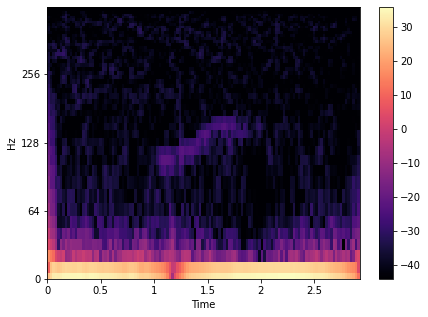

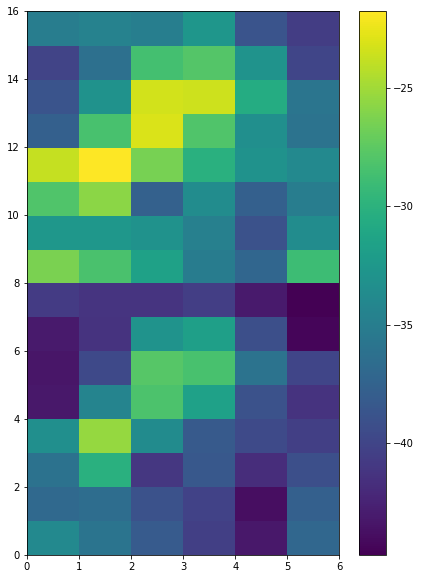

In [69]:
# проверяем редуцированную спектрограмму
import matplotlib.pyplot as plt

x , sr = librosa.load(files[my_file_num])
x = trim_and_fade(x)

X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(7, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.ylim((0, 500))

# редуцированная спектрограмма считает только по куску сигнла
data = reduced_specgram(x[round(positive_range[0]*sr):round(positive_range[1]*sr)], sr)
print('number of features: ' + repr(len(data)))
data_reshape = np.reshape(np.array(data), (num_cells[0]*2, num_cells[1]))
plt.figure(figsize=(7, 10))
plt.pcolor(data_reshape)
plt.colorbar()
plt.plot()

In [70]:
# создаем обучение по большим окнам

import numpy as np
from tqdm import tqdm as tqdm
import warnings

first = True
warnings.resetwarnings()
ws = round((positive_range[1]-positive_range[0])*sr)

X3 = [] 
Y3 = []
for id, file in tqdm(enumerate(files), total=len(files)):
    x , sr = librosa.load(file)
    x = trim_and_fade(x)
  
    if False: # опция А -  из "0" можно вырезать два окна, из "1" -- одно окно по центру
        if labels[id]:
            n1 = round(positive_range[0]*sr)
            n2 = round(positive_range[1]*sr)
            features = reduced_specgram(x[n1:n2], sr)
            X3.append(features)
            Y3.append(1)
        else:
            for wi in range(0,2):
                if wi==0:
                    wx = x[:ws]
                else:
                    wx = x[-ws:]
                features = reduced_specgram(wx, sr)
                X3.append(features)
                Y3.append(0)
    if True: # опция Б - по честному из всех файлов вырезаем одно и то же место
        n1 = round(positive_range[0]*sr)
        n2 = round(positive_range[1]*sr)
        features = reduced_specgram(x[n1:n2], sr)
        X3.append(features)
        Y3.append(labels[id])

    if first:
        warnings.simplefilter("ignore")
        first = False
warnings.resetwarnings()

  0%|          | 0/1767 [00:00<?, ?it/s]/home/latna/.local/lib/python3.9/site-packages/librosa/util/utils.py:2099: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.dtype(np.float): np.complex,
/home/latna/.local/lib/python3.9/site-packages/librosa/util/utils.py:2099: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.dtype(np.float

In [71]:
import xgboost as xgb
model3 = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5,  n_estimators = 500, scale_pos_weight=12)

/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y3, test_size=0.5, random_state=123)
model3.fit(np.array( X3_train) ,np.array(Y3_train), verbose=True )

[13:42:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=24, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=12, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [73]:
preds3 = model3.predict(np.array(X3_test))

In [74]:
# reduced specgram by files
from sklearn.metrics import mean_squared_error, precision_score, balanced_accuracy_score, f1_score, recall_score, accuracy_score, plot_roc_curve, roc_auc_score, roc_curve
from sklearn.preprocessing import binarize
print("rms: %f" % np.sqrt(mean_squared_error(Y3_test, preds3)))
print("Precision score: ",  precision_score(Y3_test,  binarize(preds3.reshape(-1, 1), threshold=0.5)))
print("Recall score: ",  recall_score(Y3_test,  binarize(preds3.reshape(-1, 1), threshold=0.5)))
print("Accuracy score: ",  accuracy_score(Y3_test,  binarize(preds3.reshape(-1, 1), threshold=0.5)))
print("Balanced accuracy score: ",  balanced_accuracy_score(Y3_test,  binarize(preds3.reshape(-1, 1), threshold=0.5)))
print("F1 score: ",  f1_score(Y3_test,  binarize(preds3.reshape(-1, 1), threshold=0.5)))
print("F1 weighted score: ",  f1_score(Y3_test,  binarize(preds3.reshape(-1, 1), threshold=0.5), average = 'weighted'))

rms: 0.368107
Precision score:  0.7734939759036145
Recall score:  0.8629032258064516
Accuracy score:  0.8359728506787331
Balanced accuracy score:  0.8396547379032258
F1 score:  0.8157560355781449
F1 weighted score:  0.8368590107697883


In [ ]:
# stacking rock auc 
from matplotlib import pyplot
ns_probs = [0 for _ in range(len(Y3_test))]
# calculate scores
ns_auc = roc_auc_score(Y3_test,, ns_probs)
lr_auc = roc_auc_score(Y3_test,, files_preds)
# summarize scores
print('Constant negative: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y3_test,, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y3_test,, files_preds)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Constant negative')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()



---



In [78]:
prepared_Y3_train = [[i] for i in Y3_train]

In [75]:
dal_model3 = d4p.gbt_regression_training()

/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [80]:
%%time
dal_model3_train_results = dal_model3.compute(np.array(X3_train), np.array(prepared_Y3_train))

CPU times: user 2.6 s, sys: 0 ns, total: 2.6 s
Wall time: 494 ms


In [81]:
dal_model3_test = d4p.gbt_regression_prediction()

In [95]:
dal_predict3_result = dal_model3_test.compute(np.array(X3_test), dal_model3_train_results.model)

/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [96]:
printMetrics(np.array(Y3_test), dal_predict3_result.prediction, 0.5)

rms: 0.370036
Precision score:  0.779291553133515
Recall score:  0.7688172043010753
Accuracy score:  0.8110859728506787
Balanced accuracy score:  0.8053070396505376
F1 score:  0.774018944519621
F1 weighted score:  0.8109058609540262


/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Constant negative: ROC AUC=0.500
Logistic: ROC AUC=0.886


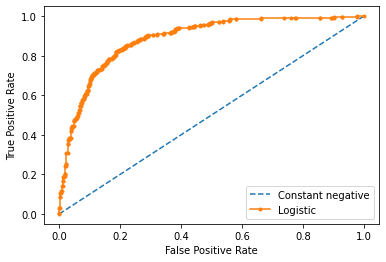

In [98]:
# stacking rock auc 
from matplotlib import pyplot
ns_probs = [0 for _ in range(len(Y3_test))]
# calculate scores
ns_auc = roc_auc_score(Y3_test, ns_probs)
lr_auc = roc_auc_score(Y3_test, dal_predict3_result.prediction)
# summarize scores
print('Constant negative: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y3_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y3_test, dal_predict3_result.prediction)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Constant negative')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()